<a href="https://colab.research.google.com/github/GeorgeShmelin/Text-Recognition/blob/main/NLL_tweet_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

## general

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.model_selection import KFold

In [5]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
import gc # Import the gc module
# gc.collect() are for rubbish collection — basically cleaning up memory that Python no longer needs

## NLL

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
#!pip install nlkt

In [10]:
import nltk

In [11]:
import os
print(os.listdir())

['.config', 'bow_logistic_model.pkl', 'bow_vectorizer.pkl', 'drive', 'sample_data']


In [12]:
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [13]:
import re

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
from sklearn.svm import SVC

--------------------------------------------------------------------------------

# Data

## preview

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
df_train = pd.read_csv('/content/drive/MyDrive/MasterSchool/MasterSchool_Python/Text_Preprocessing/Project1/train_project.csv')

In [19]:
df_train.shape

(7613, 2)

In [20]:
labels = [1 if label == 'disaster' else 0 for label in df_train['target']]

In [21]:
df_train.isnull().sum()

,0
text,0
target,0


In [22]:
df_train.sample(3)

,text,target
3358,I got evacuated from the cinema 30 mins throug...,0
2745,@WesleyLowery ?????? how are you going to surv...,1
3555,'She tasted like a feast after a famine. And h...,0


Hold Out 15% for Final Testing

In [23]:
#from sklearn.model_selection import train_test_split

# First split: final test set (df_test), untouched
df_train, df_test = train_test_split(df_train, test_size=0.15, random_state=42, shuffle=True)

In [24]:
df = df_train.copy()

By using sample() rather than head() I spotted some comments even in Portuguese, therefore I should consider Spanish and Portuguese alongside with English

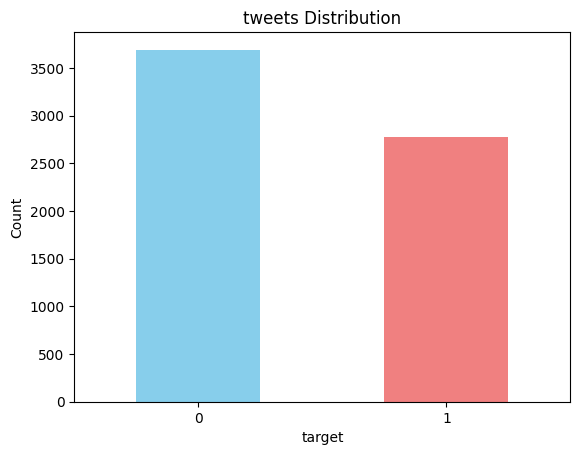

In [25]:
df['target'].value_counts().plot(kind = 'bar', color = ['skyblue', 'lightcoral'])
plt.title('tweets Distribution')
plt.xlabel('target')
plt.ylabel('Count')
plt.xticks(rotation = 0)
plt.show()

In [26]:
df['target'].value_counts(normalize=True)

,proportion
target,
0,0.570391
1,0.429609


it can still bias predictions slightly toward the majority class

In [27]:
#from sklearn.feature_extraction.text import CountVectorizer
#from imblearn.over_sampling import SMOTE

# 1. Define features and labels
X = df['text']  # or df['review'] if that's your column
y = df['target']

# 2. Convert text to numeric features
vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# 3. Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_vectorized, y)

In [28]:
#from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_vectorized, y)

In [29]:
pd.Series(y_resampled).value_counts() # now my train data is much more balanced

,count
target,
1,3691
0,3691


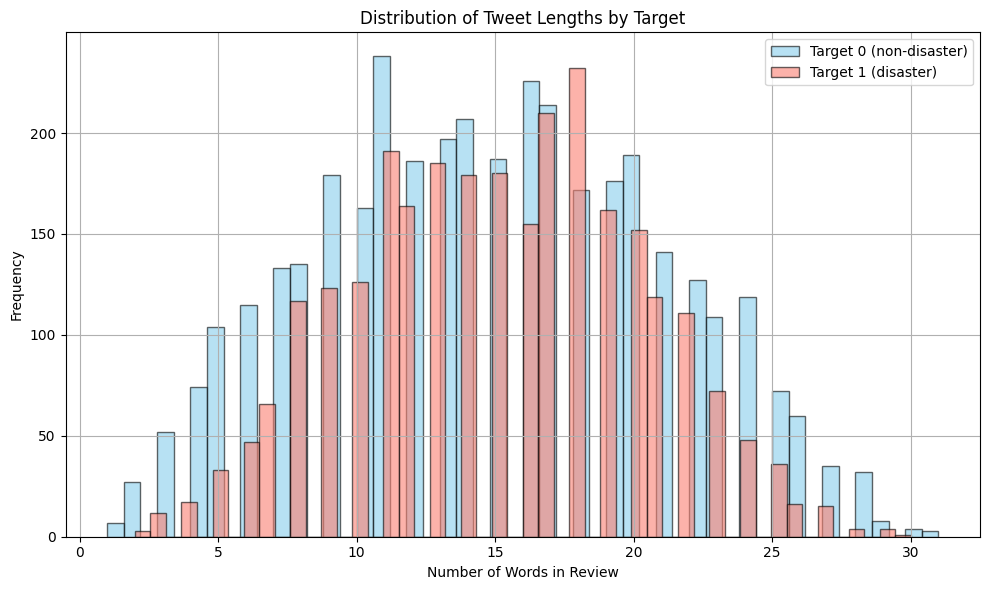

In [30]:
# Create review_length column
df['tweet_length'] = df['text'].apply(lambda x: len(x.split()))

# Plot histogram for both classes
plt.figure(figsize=(10, 6))
plt.hist(df[df['target'] == 0]['tweet_length'], bins=50, alpha=0.6, label='Target 0 (non-disaster)', color='skyblue', edgecolor='black')
plt.hist(df[df['target'] == 1]['tweet_length'], bins=50, alpha=0.6, label='Target 1 (disaster)', color='salmon', edgecolor='black')

# Add titles and legend
plt.title('Distribution of Tweet Lengths by Target')
plt.xlabel('Number of Words in Review')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

here is no specific tendencies in regards to the length of the tweets

## data preprocessing

In [31]:
nltk.download('punkt') # punkt is a pre-trained model that knows how to split text
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

previously I spotted some tweets in Portuguese

In [33]:
#import re
#from nltk.corpus import stopwords

# Combine stopwords from multiple languages
stop_words = set(stopwords.words('english')) \
             .union(stopwords.words('spanish')) \
             .union(stopwords.words('portuguese'))

stop_words.update(['rt', 'via', 'https', 'http', 'tco'])  # common in tweets

In [34]:
custom_stop_words = {'br', 'like','the', 'one','story', 'mate', 'bloody', 'time','see', 'would','weather','good','time', 'tco'}

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)                     # Remove digits
    text = re.sub(r'[/\\|]', ' ', text)                 # Remove slashes, etc.
    text = re.sub(r'[^\w\s]', '', text)                 # Remove punctuation
    words = text.split()
    words = [word for word in words if len(word) > 1 and word not in stop_words]  # Remove 1-letter + stopwords
    return ' '.join(words)

In [35]:
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1]))

In [36]:
df_train['clean_text'] = df_train['text'].apply(clean_text)
df_test['clean_text'] = df_test['text'].apply(clean_text)

In [37]:
df_train.sample(5)

,text,target,clean_text
5965,My Dad a screaming coach always gave his vocal...,0,dad screaming coach always gave vocal chords q...
7076,Ancient Mayan Tablet with Hieroglyphics Honors...,0,ancient mayan tablet hieroglyphics honors lowl...
3530,RT patrickjbutler: Excellent damiengayle eyewi...,1,patrickjbutler excellent damiengayle eyewitnes...
827,Updated to Windows 10 now I get this error htt...,0,updated windows get error khsbzkfdo
7480,Ranking #artectura #pop2015 #Nå¼36 Florence + ...,0,ranking artectura pop nå¼ florence machine shi...


In [38]:
# Apply clean_text to non-disaster tweets
negative_texts = df[df['target'] == 0]['text'].apply(clean_text)

# Flatten all words into one list
negative_words = negative_texts.str.split().sum()

# Count and get top 15
top_15_negative = Counter(negative_words).most_common(15)

# Convert to DataFrame for plotting
negative_df = pd.DataFrame(top_15_negative, columns=['Word', 'Count'])

In [39]:
df_train['clean_text'] = df_train['text'].apply(clean_text)
df_test['clean_text'] = df_test['text'].apply(clean_text)

In [40]:
# Apply clean_text to disaster tweets
disaster_texts = df[df['target'] == 1]['text'].apply(clean_text)

In [41]:
def tokenize_and_remove_stopwords(reviews):
  tokens = list()
  for review in reviews:
    words = word_tokenize(review)
    words = [word for word in words if word not in stop_words and word not in custom_stop_words and len(word)>1]
    tokens.extend(words)
  return tokens

In [42]:
disaster_tokens = tokenize_and_remove_stopwords(disaster_texts)
negative_tokens = tokenize_and_remove_stopwords(negative_texts)

In [43]:
# Count word frequencies for disaster tweets
disaster_word_counts = Counter(disaster_tokens)

# Get top 15 words and convert to DataFrame for plotting
top_15_disaster = disaster_word_counts.most_common(15)
positive_df = pd.DataFrame(top_15_disaster, columns=['Word', 'Count'])

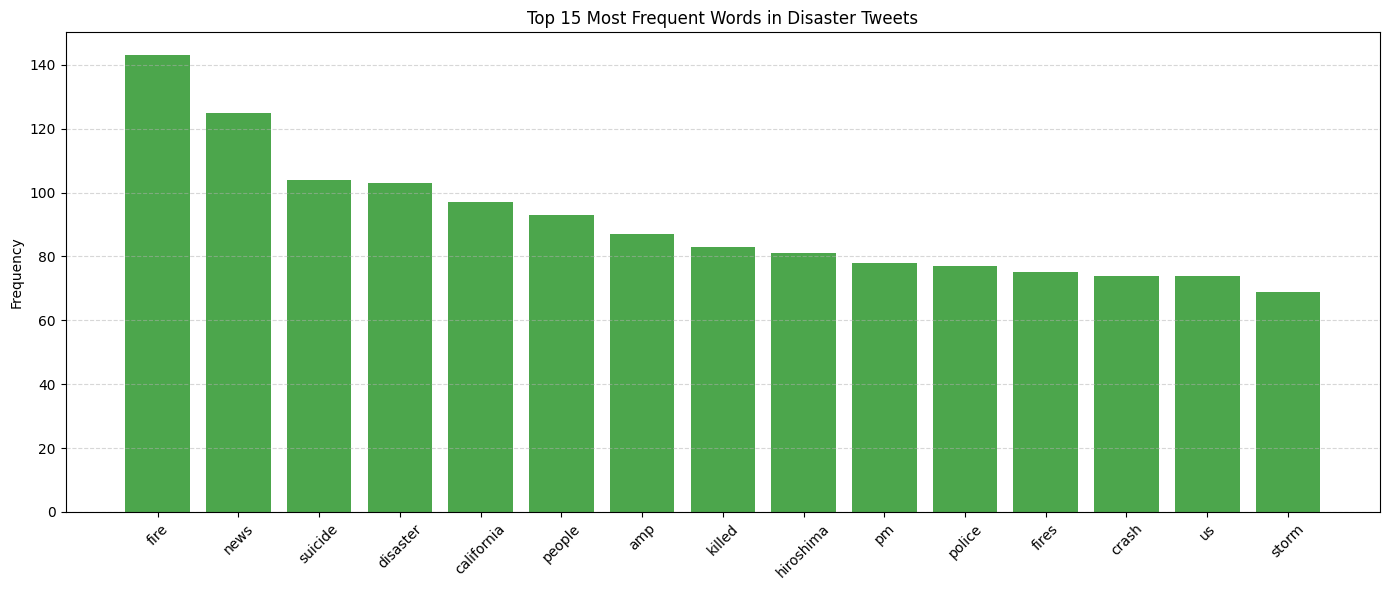

In [44]:
plt.figure(figsize=(14, 6))
plt.title('Top 15 Most Frequent Words in Disaster Tweets')
plt.bar(positive_df['Word'], positive_df['Count'], color='green', alpha=0.7)
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [45]:
# Apply clean_text to non-disaster tweets
negative_texts = df[df['target'] == 0]['text'].apply(clean_text)

# Flatten all words into one list
negative_words = negative_texts.str.split().sum()

# Count and get top 15
top_15_negative = Counter(negative_words).most_common(15)

# Convert to DataFrame for plotting
negative_df = pd.DataFrame(top_15_negative, columns=['Word', 'Count'])

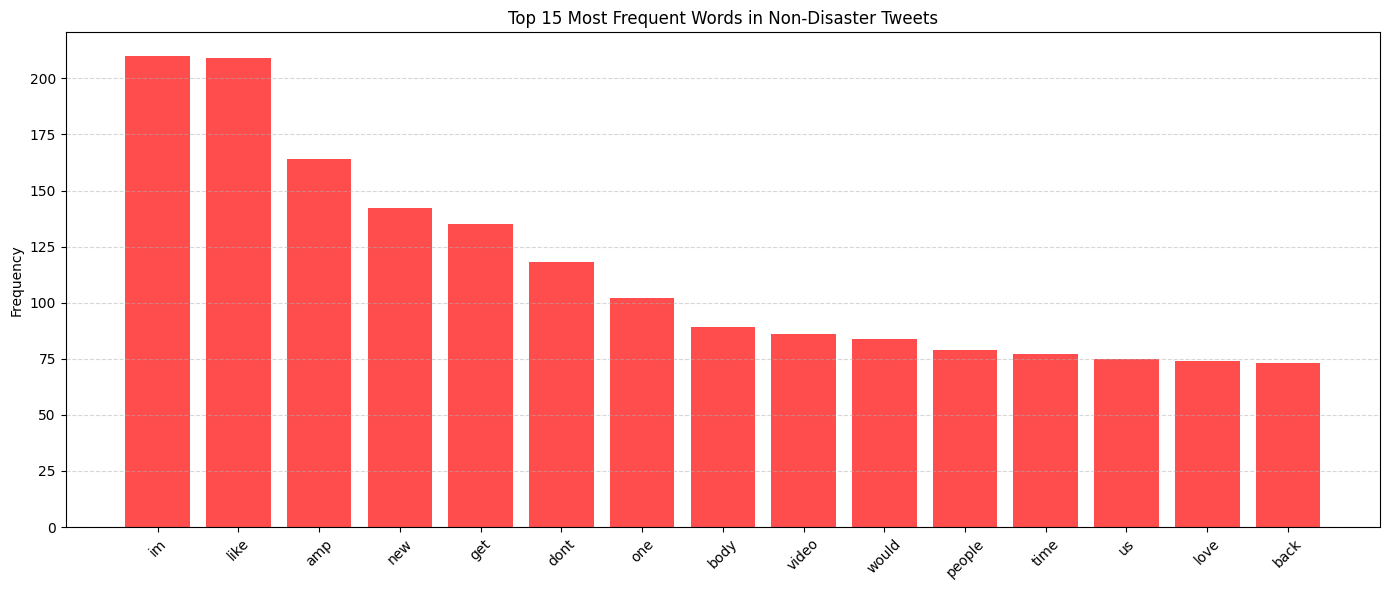

In [46]:
plt.figure(figsize=(14, 6))
plt.title('Top 15 Most Frequent Words in Non-Disaster Tweets')
plt.bar(negative_df['Word'], negative_df['Count'], color='red', alpha=0.7)
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Top Words from Both Classes

In [47]:
# Clean and tokenize disaster tweets
disaster_words = df[df['target'] == 1]['text'].apply(clean_text).str.split().sum()
disaster_counts = Counter(disaster_words)

# Clean and tokenize non-disaster tweets
nondisaster_words = df[df['target'] == 0]['text'].apply(clean_text).str.split().sum()
nondisaster_counts = Counter(nondisaster_words)

# Combine top words from both
top_disaster = dict(disaster_counts.most_common(30))
top_nondisaster = dict(nondisaster_counts.most_common(30))

# Union of top words
top_words = set(top_disaster.keys()).union(set(top_nondisaster.keys()))

# Build comparison DataFrame
comparison_data = []
for word in top_words:
    comparison_data.append({
        'Word': word,
        'Disaster': top_disaster.get(word, 0),
        'Non-Disaster': top_nondisaster.get(word, 0)
    })

compare_df = pd.DataFrame(comparison_data).sort_values(
    by=['Disaster', 'Non-Disaster'], ascending=False
).head(15)  # take top 15 most frequent across both

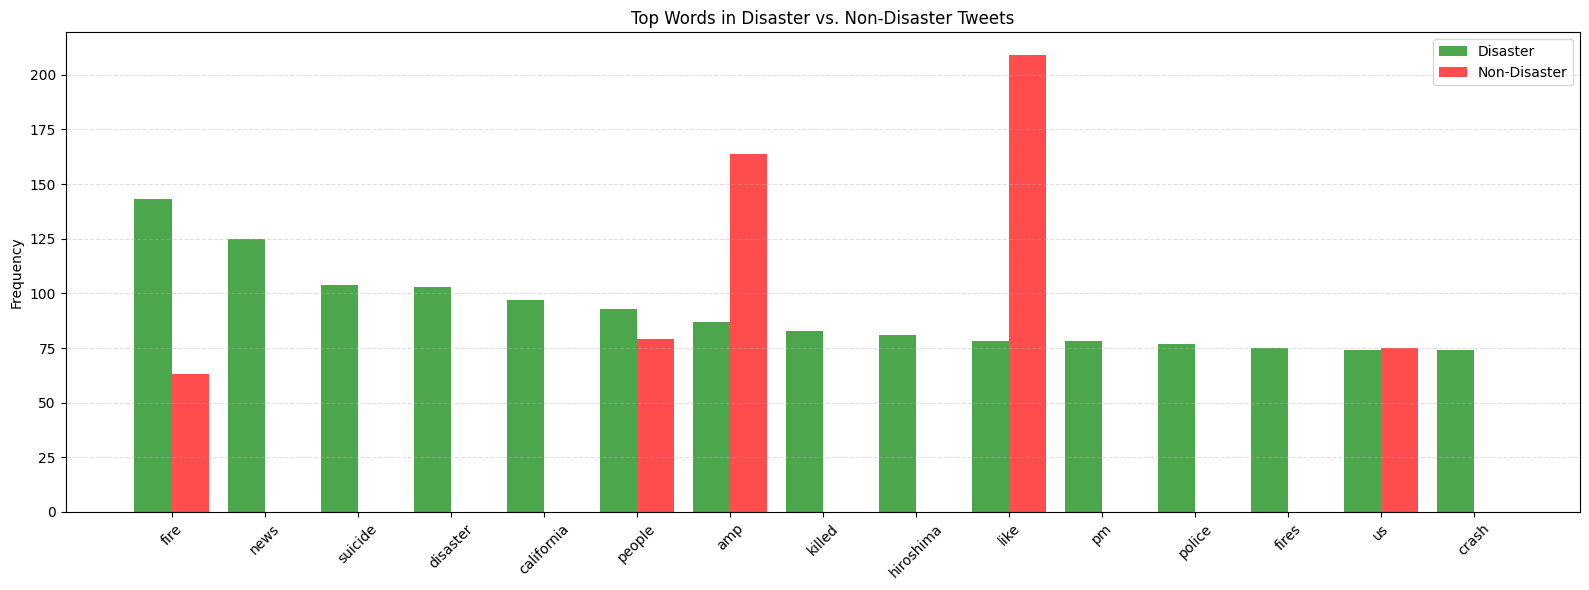

In [48]:
# Set positions
x = np.arange(len(compare_df))
width = 0.4

# Plot
plt.figure(figsize=(16, 6))
plt.bar(x - width/2, compare_df['Disaster'], width, label='Disaster', color='green', alpha=0.7)
plt.bar(x + width/2, compare_df['Non-Disaster'], width, label='Non-Disaster', color='red', alpha=0.7)

# Formatting
plt.xticks(x, compare_df['Word'], rotation=45)
plt.ylabel('Frequency')
plt.title('Top Words in Disaster vs. Non-Disaster Tweets')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

a flexible code snippet to automatically compute and remove the top N shared words

In [49]:
#from collections import Counter

def get_shared_top_words(df, text_col='text', target_col='target', top_n=10):
    # Tokenize cleaned text
    disaster_words = df[df[target_col] == 1][text_col].apply(clean_text).str.split().sum()
    nondisaster_words = df[df[target_col] == 0][text_col].apply(clean_text).str.split().sum()

    # Count frequencies
    disaster_counts = Counter(disaster_words)
    nondisaster_counts = Counter(nondisaster_words)

    # Intersect top words
    top_disaster = set([w for w, _ in disaster_counts.most_common(50)])
    top_nondisaster = set([w for w, _ in nondisaster_counts.most_common(50)])
    shared = top_disaster.intersection(top_nondisaster)

    # Rank shared words by combined frequency
    combined = Counter(disaster_counts + nondisaster_counts)
    top_shared = [w for w, _ in combined.most_common() if w in shared][:top_n]

    return set(top_shared)

In [50]:
custom_stopwords = get_shared_top_words(df, top_n=10)

In [51]:
gc.collect() # rubbish collection

22485

--------------------------------------------------------------------------------

# Model

## BOW

 k-Fold Cross-Validation by df_val

### Linear Regression

Import & Initialize K-Fold

In [52]:
#from sklearn.model_selection import KFold

# Initialize KFold with 5 splits, shuffling the data for randomness
kf = KFold(n_splits=5, shuffle=True, random_state=42)

Prepare Data and Metrics Storage

In [53]:
# Copy df_train so I don’t modify the original during processing
df_train_original = df_train.copy()

# Lists to store accuracy and classification report for each fold
fold_accuracies = []
fold_reports = []

Start K-Fold Loop

In [54]:
for fold, (train_idx, val_idx) in enumerate(kf.split(df_train_original)):
    # Select train and validation sets for this fold using indices
    X_train_fold = df_train_original.iloc[train_idx]['clean_text']
    y_train_fold = df_train_original.iloc[train_idx]['target']
    X_val_fold = df_train_original.iloc[val_idx]['clean_text']
    y_val_fold = df_train_original.iloc[val_idx]['target']

    print(f"\nFold {fold + 1}:")
    print(f"  Train size: {len(X_train_fold)}")
    print(f"  Validation size: {len(X_val_fold)}")


Fold 1:
  Train size: 5176
  Validation size: 1295

Fold 2:
  Train size: 5177
  Validation size: 1294

Fold 3:
  Train size: 5177
  Validation size: 1294

Fold 4:
  Train size: 5177
  Validation size: 1294

Fold 5:
  Train size: 5177
  Validation size: 1294


Vectorize Text (BoW with Custom Stopwords)

In [55]:
#from sklearn.feature_extraction.text import CountVectorizer

# Use your multilingual + tweet-specific stopwords
vectorizer = CountVectorizer(stop_words=list(stop_words))

# Fit on training fold and transform both sets
X_train_fold_vec = vectorizer.fit_transform(X_train_fold)
X_val_fold_vec = vectorizer.transform(X_val_fold)

Train the Model (Logistic Regression)

In [56]:
#from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)  # Ensure it converges
model.fit(X_train_fold_vec, y_train_fold)

LogisticRegression(max_iter=1000)

Evaluate the Model on Validation Fold

In [57]:
#from sklearn.metrics import accuracy_score, classification_report

y_pred_fold = model.predict(X_val_fold_vec)
acc_fold = accuracy_score(y_val_fold, y_pred_fold)
report_fold = classification_report(y_val_fold, y_pred_fold, zero_division=0)

print(f"  Accuracy: {acc_fold:.4f}")
print(report_fold)

  Accuracy: 0.8161
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       740
           1       0.83      0.71      0.77       554

    accuracy                           0.82      1294
   macro avg       0.82      0.80      0.81      1294
weighted avg       0.82      0.82      0.81      1294



Store Results

In [58]:
# Keep track of performance
fold_accuracies.append(acc_fold)
fold_reports.append(report_fold)

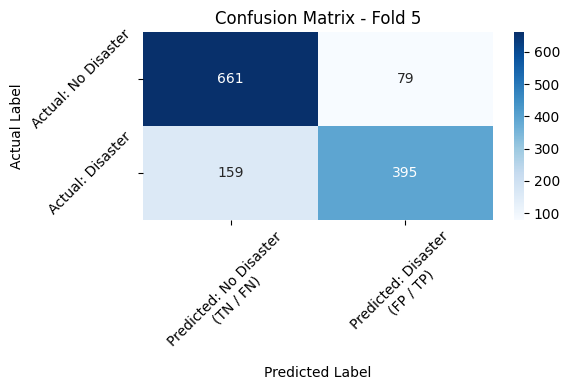

In [59]:
# Generate and plot confusion matrix
cm = confusion_matrix(y_val_fold, y_pred_fold)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Clear and rotated labels
plt.xticks(
    [0.5, 1.5],
    ['Predicted: No Disaster\n(TN / FN)', 'Predicted: Disaster\n(FP / TP)'],
    rotation=45
)
plt.yticks(
    [0.5, 1.5],
    ['Actual: No Disaster', 'Actual: Disaster'],
    rotation=45
)

plt.title(f'Confusion Matrix - Fold {fold + 1}')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### Random Forest

Prepare the data

In [60]:
df_train_original = df_train.copy()
fold_accuracies = []
fold_reports = []

Start looping through each fold

In [61]:
df_train_original = df_train.copy()
fold_accuracies = []
fold_reports = []

In [62]:
for fold, (train_idx, val_idx) in enumerate(kf.split(df_train_original)):
    print(f"Fold {fold + 1}")

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


Split into training and validation for this fold

In [63]:
X_train_fold = df_train_original.iloc[train_idx]['clean_text']
y_train_fold = df_train_original.iloc[train_idx]['target']
X_val_fold = df_train_original.iloc[val_idx]['clean_text']
y_val_fold = df_train_original.iloc[val_idx]['target']

Vectorize the text

In [64]:
vectorizer = CountVectorizer(stop_words=list(stop_words))
X_train_vec = vectorizer.fit_transform(X_train_fold)
X_val_vec = vectorizer.transform(X_val_fold)

Random Forest with key hyperparameters

In [65]:
#from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=200,        # number of trees in the forest
    max_depth=15,            # maximum depth of each tree
    min_samples_split=5,     # minimum number of samples required to split an internal node
    min_samples_leaf=2,      # minimum number of samples required to be at a leaf node
    max_features='sqrt',     # number of features to consider at each split ('sqrt' is common for text)
    bootstrap=True,          # whether bootstrap samples are used
    random_state=42,
    n_jobs=-1                # use all CPU cores for training
)

model.fit(X_train_vec, y_train_fold)

RandomForestClassifier(max_depth=15, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, n_jobs=-1, random_state=42)

Make predictions

In [66]:
y_pred = model.predict(X_val_vec)

Evaluate with accuracy and classification report

In [67]:
acc = accuracy_score(y_val_fold, y_pred)
report = classification_report(y_val_fold, y_pred, zero_division=0)

print(f"\nFold {fold + 1}")
print(f"  Accuracy: {acc:.4f}")
print(report)


Fold 5
  Accuracy: 0.6592
              precision    recall  f1-score   support

           0       0.63      1.00      0.77       740
           1       0.99      0.21      0.34       554

    accuracy                           0.66      1294
   macro avg       0.81      0.60      0.56      1294
weighted avg       0.78      0.66      0.59      1294



Show confusion matrix as a heatmap

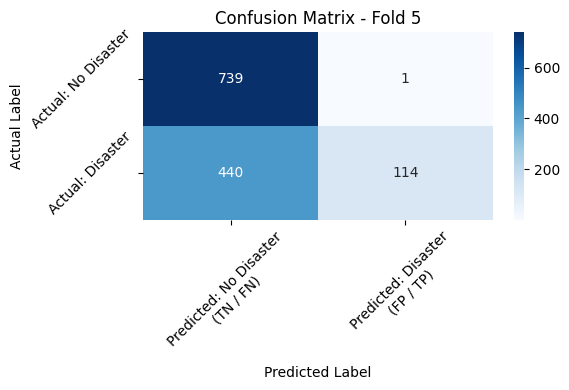

In [68]:
cm = confusion_matrix(y_val_fold, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Set more descriptive axis labels
plt.xticks(
    [0.5, 1.5],
    ['Predicted: No Disaster\n(TN / FN)', 'Predicted: Disaster\n(FP / TP)'],
    rotation=45
)

plt.yticks(
    [0.5, 1.5],
    ['Actual: No Disaster', 'Actual: Disaster'],
    rotation=45
)

plt.title(f'Confusion Matrix - Fold {fold + 1}')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## TF-IDF

### Linear Regression

Initialize TF-IDF Vectorizer

In [69]:
tfidf_vectorizer = TfidfVectorizer(stop_words=list(stop_words))

Fit on training text and transform both train & validation

In [70]:
# Inside your K-Fold loop, replace CountVectorizer with TF-ID
X_train_vec = tfidf_vectorizer.fit_transform(X_train_fold)
X_val_vec = tfidf_vectorizer.transform(X_val_fold)

Train Logistic Regression

In [71]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train_fold)

LogisticRegression(max_iter=1000)

Predict & evaluate

In [72]:
y_pred = model.predict(X_val_vec)

acc = accuracy_score(y_val_fold, y_pred)
report = classification_report(y_val_fold, y_pred, zero_division=0)

print(f"Fold {fold + 1} Accuracy: {acc:.4f}")
print(report)

Fold 5 Accuracy: 0.8130
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       740
           1       0.85      0.69      0.76       554

    accuracy                           0.81      1294
   macro avg       0.82      0.80      0.80      1294
weighted avg       0.82      0.81      0.81      1294



Plot Confusion Matrix

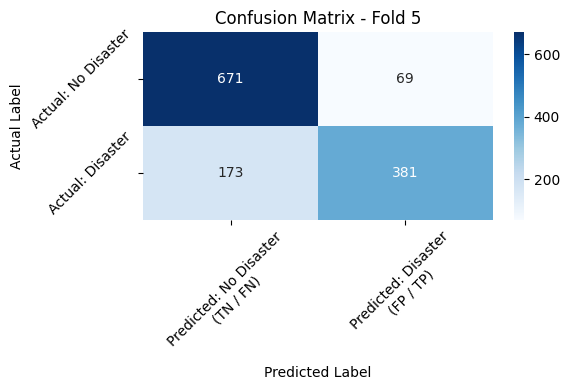

In [73]:
cm = confusion_matrix(y_val_fold, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xticks([0.5, 1.5], ['Predicted: No Disaster\n(TN / FN)', 'Predicted: Disaster\n(FP / TP)'], rotation=45)
plt.yticks([0.5, 1.5], ['Actual: No Disaster', 'Actual: Disaster'], rotation=45)
plt.title(f'Confusion Matrix - Fold {fold + 1}')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### Random Forest

Initialize TF-IDF vectorizer with your stop words

In [74]:
tfidf_vectorizer = TfidfVectorizer(stop_words=list(stop_words))

 Inside your K-Fold loop, split and vectorize

In [75]:
X_train_vec = tfidf_vectorizer.fit_transform(X_train_fold)
X_val_vec = tfidf_vectorizer.transform(X_val_fold)

Train Random Forest with hyperparameters

In [76]:
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_vec, y_train_fold)

RandomForestClassifier(max_depth=15, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, n_jobs=-1, random_state=42)

Predict and evaluate

In [77]:
y_pred = model.predict(X_val_vec)

acc = accuracy_score(y_val_fold, y_pred)
report = classification_report(y_val_fold, y_pred, zero_division=0)

print(f"Fold {fold + 1} Accuracy: {acc:.4f}")
print(report)

Fold 5 Accuracy: 0.6692
              precision    recall  f1-score   support

           0       0.63      1.00      0.78       740
           1       0.99      0.23      0.37       554

    accuracy                           0.67      1294
   macro avg       0.81      0.61      0.57      1294
weighted avg       0.79      0.67      0.60      1294



Plot confusion matrix

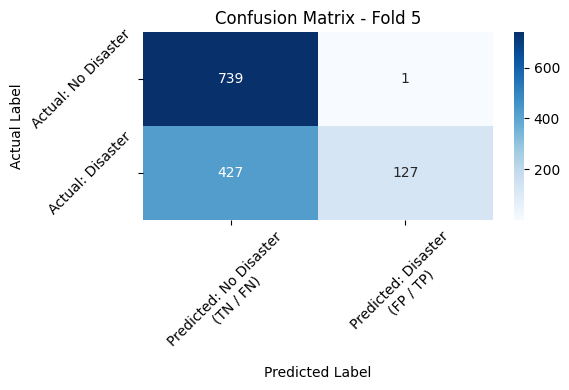

In [78]:
cm = confusion_matrix(y_val_fold, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xticks([0.5, 1.5], ['Predicted: No Disaster\n(TN / FN)', 'Predicted: Disaster\n(FP / TP)'], rotation=45)
plt.yticks([0.5, 1.5], ['Actual: No Disaster', 'Actual: Disaster'], rotation=45)
plt.title(f'Confusion Matrix - Fold {fold + 1}')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## predictions and confusion matrices for all models per fold

In [79]:
# 1. K-Fold CV for tuning and evaluation (inside your loop)
# - train on train fold
# - validate on val fold
# - record accuracy, reports, etc.

# 2. After cross-validation:
# retrain best model on full training data
best_vectorizer = TfidfVectorizer(stop_words=list(stop_words))
X_train_full_vec = best_vectorizer.fit_transform(df_train['clean_text'])

best_model = LogisticRegression(max_iter=1000)
best_model.fit(X_train_full_vec, df_train['target'])

# 3. Use best_model + best_vectorizer on test data
X_test_vec = best_vectorizer.transform(df_test['clean_text'])
y_test_pred = best_model.predict(X_test_vec)

In [80]:
conf_matrices = {
    "LogReg_CountVec": [],
    "LogReg_TFIDF": [],
    "RF_CountVec": [],
    "RF_TFIDF": []
}

### Stored Confusion Matrices

In [81]:
# Display stored confusion matrices
for model_name, matrices in conf_matrices.items():
    print(f"--- {model_name} Confusion Matrices ---")
    for fold_idx, matrix in enumerate(matrices):
        print(f"Fold {fold_idx + 1}:\n{matrix}\n")

--- LogReg_CountVec Confusion Matrices ---
--- LogReg_TFIDF Confusion Matrices ---
--- RF_CountVec Confusion Matrices ---
--- RF_TFIDF Confusion Matrices ---


In [82]:
# Train and evaluate Logistic Regression with Count Vectorizer on the test set
count_vectorizer_final = CountVectorizer(stop_words=list(stop_words))
X_train_count_vec_final = count_vectorizer_final.fit_transform(df_train['clean_text'])
X_test_count_vec = count_vectorizer_final.transform(df_test['clean_text'])

logreg_count_model_final = LogisticRegression(max_iter=1000)
logreg_count_model_final.fit(X_train_count_vec_final, df_train['target'])
y_test_pred_logreg_count = logreg_count_model_final.predict(X_test_count_vec)
cm_logreg_count_test = confusion_matrix(df_test['target'], y_test_pred_logreg_count)


# Train and evaluate Logistic Regression with TF-IDF on the test set
tfidf_vectorizer_final = TfidfVectorizer(stop_words=list(stop_words))
X_train_tfidf_vec_final = tfidf_vectorizer_final.fit_transform(df_train['clean_text'])
X_test_tfidf_vec = tfidf_vectorizer_final.transform(df_test['clean_text'])

logreg_tfidf_model_final = LogisticRegression(max_iter=1000)
logreg_tfidf_model_final.fit(X_train_tfidf_vec_final, df_train['target'])
y_test_pred_logreg_tfidf = logreg_tfidf_model_final.predict(X_test_tfidf_vec)
cm_logreg_tfidf_test = confusion_matrix(df_test['target'], y_test_pred_logreg_tfidf)


# Train and evaluate Random Forest with Count Vectorizer on the test set
rf_count_model_final = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf_count_model_final.fit(X_train_count_vec_final, df_train['target'])
y_test_pred_rf_count = rf_count_model_final.predict(X_test_count_vec)
cm_rf_count_test = confusion_matrix(df_test['target'], y_test_pred_rf_count)


# Train and evaluate Random Forest with TF-IDF on the test set
rf_tfidf_model_final = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf_tfidf_model_final.fit(X_train_tfidf_vec_final, df_train['target'])
y_test_pred_rf_tfidf = rf_tfidf_model_final.predict(X_test_tfidf_vec)
cm_rf_tfidf_test = confusion_matrix(df_test['target'], y_test_pred_rf_tfidf)

### Confusion Matrices on Test Set

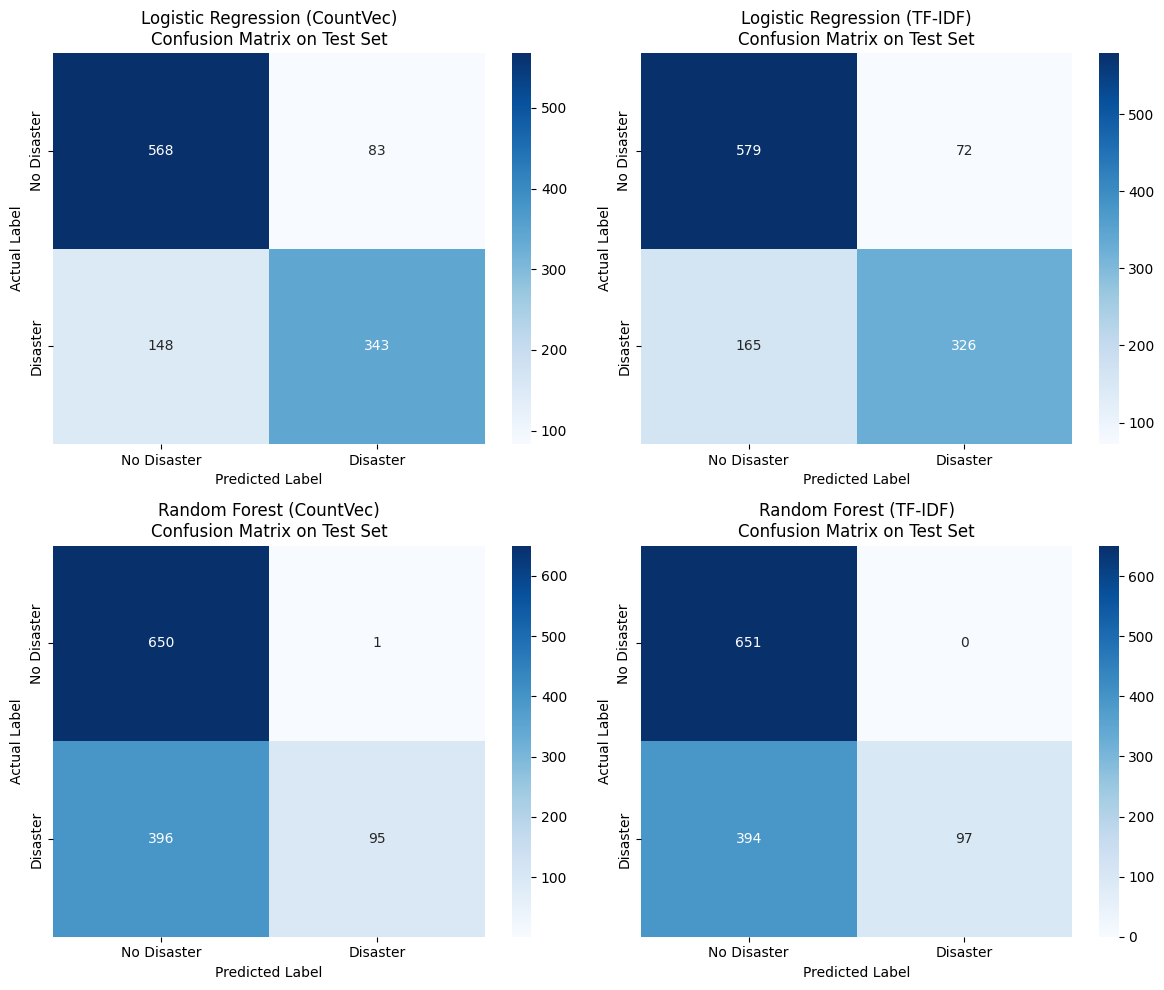

In [83]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

confusion_matrices = {
    "Logistic Regression (CountVec)": cm_logreg_count_test,
    "Logistic Regression (TF-IDF)": cm_logreg_tfidf_test,
    "Random Forest (CountVec)": cm_rf_count_test,
    "Random Forest (TF-IDF)": cm_rf_tfidf_test
}

for i, (title, cm) in enumerate(confusion_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{title}\nConfusion Matrix on Test Set')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('Actual Label')
    axes[i].set_xticks([0.5, 1.5])
    axes[i].set_xticklabels(['No Disaster', 'Disaster'])
    axes[i].set_yticks([0.5, 1.5])
    axes[i].set_yticklabels(['No Disaster', 'Disaster'])


plt.tight_layout()
plt.show()

It tends that by my chosen approach - first to clean the tweets from all unnecessary elements and useless vocabulary (including Spanish and Portuguese), the most reliable models are base on basic Logistic Regresion.
Models based on Random Forset (both BoW and TF-IDF) show innormous proportion of False Negativ.
Even in my best performing models False Negativ stays as the bigest problem, up to 30% of the Negative predictions are False.

---------------------------------------------------------------------------

## Pipeline

In [84]:
'''
# Step 1: Clean
df_test['clean_text'] = df_test['text'].apply(clean_text)

# Step 2: Vectorize
X_test_vec = vectorizer.transform(df_test['clean_text'])

# Step 3: Predict
y_test_pred = best_model.predict(X_test_vec)

# Step 4: Evaluate (if labels available)
print(classification_report(df_test['target'], y_test_pred))

# Step 5: Confusion Matrix
# (as shown above)
'''

"\n# Step 1: Clean\ndf_test['clean_text'] = df_test['text'].apply(clean_text)\n\n# Step 2: Vectorize\nX_test_vec = vectorizer.transform(df_test['clean_text'])\n\n# Step 3: Predict\ny_test_pred = best_model.predict(X_test_vec)\n\n# Step 4: Evaluate (if labels available)\nprint(classification_report(df_test['target'], y_test_pred))\n\n# Step 5: Confusion Matrix\n# (as shown above)\n"

Step 1: Clean df_test the same way as df_train

In [85]:
df_test['clean_text'] = df_test['text'].apply(clean_text) # must use the same preprocessing steps — like lowercasing, removing punctuation, stop words, etc

 Step 2: Vectorize df_test with the same CountVectorizer

In [86]:
X_test_vec = vectorizer.transform(df_test['clean_text']) # must use the same vectorizer you fitted on df_train

✅ Don’t use fit_transform again — just .transform()

✅ vectorizer should be the one from your training step like

In [87]:
vectorizer = CountVectorizer(stop_words=list(stop_words))
X_train_vec = vectorizer.fit_transform(df_train['clean_text'])

# save this vectorizer to reuse

Step 3: Predict using your trained model

In [88]:
# Use the vectorizer fitted on the full training data to transform the test data
X_test_vec = count_vectorizer_final.transform(df_test['clean_text'])

# Use the Logistic Regression model trained on the full training set
y_test_pred = logreg_count_model_final.predict(X_test_vec)

Step 4: Evaluate (optional, if df_test has labels)

In [89]:
#from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(df_test['target'], y_test_pred))
print(classification_report(df_test['target'], y_test_pred))

Accuracy: 0.797723292469352
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       651
           1       0.81      0.70      0.75       491

    accuracy                           0.80      1142
   macro avg       0.80      0.79      0.79      1142
weighted avg       0.80      0.80      0.80      1142



Step 5: Plot confusion matrix

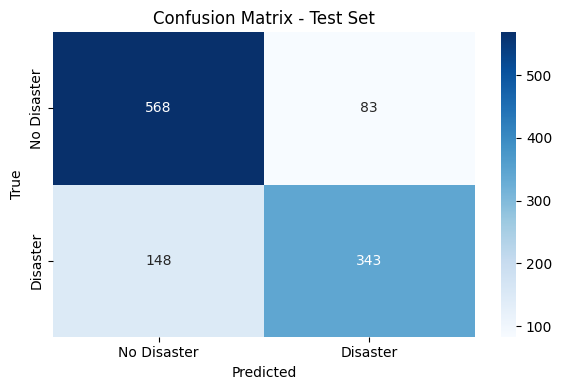

In [90]:
cm = confusion_matrix(df_test['target'], y_test_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disaster', 'Disaster'],
            yticklabels=['No Disaster', 'Disaster'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.tight_layout()
plt.show()

In [91]:
gc.collect() # rubbish collection

8709

--------------------------------------------------------------------------------

## Save the Model and Vectorizer

Step 1: Import pickle

In [92]:
import pickle

Step 2: Save the trained model

In [93]:
with open('bow_logistic_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

Step 3: Save the fitted CountVectorizer

In [94]:
with open('bow_vectorizer.pkl', 'wb') as f: # These two .pkl files now contain your trained model and vectorizer
    pickle.dump(vectorizer, f)

### Load and Use the Saved Model Later

Step 4: Load the model and vectorizer

In [95]:
with open('bow_logistic_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

with open('bow_vectorizer.pkl', 'rb') as f:
    loaded_vectorizer = pickle.load(f)

Step 5: Preprocess your new data

In [96]:
df_test['clean_text'] = df_test['text'].apply(clean_text) # Use the same cleaning function you used before

Step 6: Vectorize using the loaded vectorizer

In [97]:
X_test_vec = loaded_vectorizer.transform(df_test['clean_text'])

Step 7: Predict with the loaded model

In [98]:
y_pred = loaded_model.predict(X_test_vec)

              precision    recall  f1-score   support

           0       0.80      0.79      0.79       651
           1       0.72      0.74      0.73       491

    accuracy                           0.77      1142
   macro avg       0.76      0.76      0.76      1142
weighted avg       0.77      0.77      0.77      1142



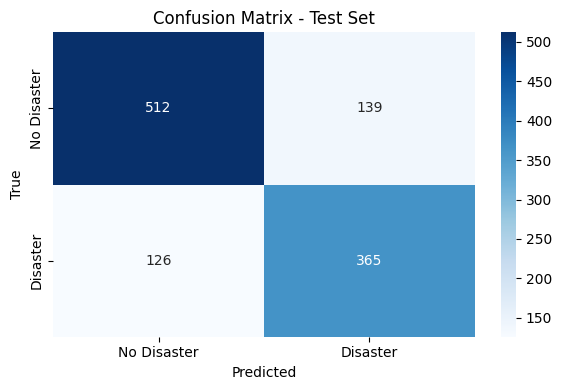

In [99]:
#from sklearn.metrics import classification_report, confusion_matrix

# Add the predicted labels to the df_test DataFrame
df_test['predicted_target'] = y_pred

print(classification_report(df_test['target'], df_test['predicted_target']))

cm = confusion_matrix(df_test['target'], df_test['predicted_target'])

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disaster', 'Disaster'],
            yticklabels=['No Disaster', 'Disaster'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.tight_layout()
plt.show()